### Preparing Training Data

In [14]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import torch

# Importing the training set
dataset_train = pd.read_csv('Stock_Price_Train.csv')
dataset_train.head()
train = dataset_train.loc[:, ["Open"]].values
dataset_train.head()

train = np.array(train)
print(train.shape)

(1258, 1)


Train Data Shape:  (1258, 1)
Normalized Train Data Shape:  (1258, 1)


<Figure size 1080x360 with 0 Axes>

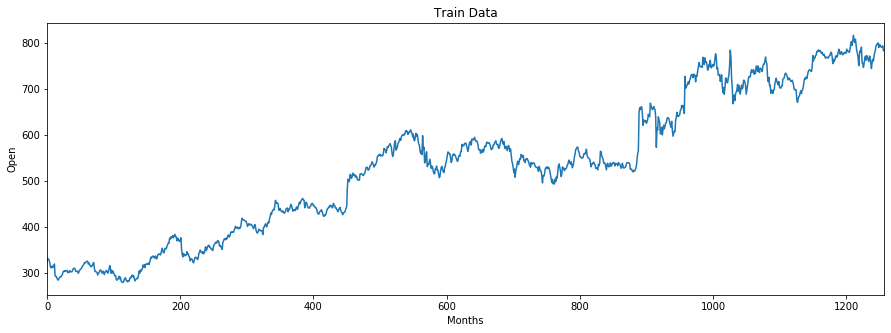

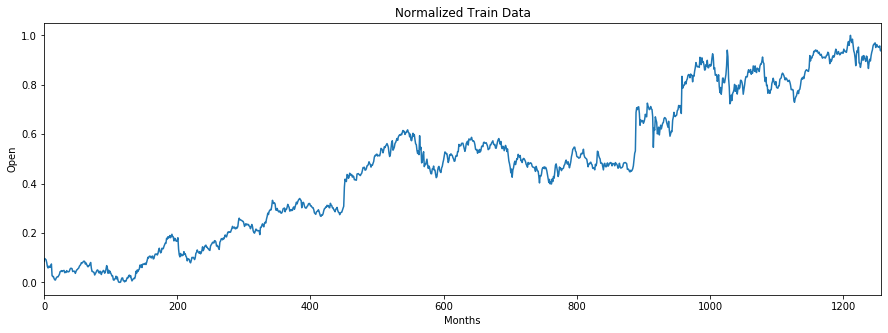

<Figure size 1080x360 with 0 Axes>

In [15]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Train Data')
plt.ylabel('Open')
plt.xlabel('Months')
plt.grid(False)
plt.autoscale(axis='x',tight=True)
plt.plot(train)

train = np.array(train).reshape((1258,1))
print("Train Data Shape: ",train.shape)

#Normalizing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train)
print("Normalized Train Data Shape: ",train.shape)

plt.figure()

plt.title('Normalized Train Data')
plt.ylabel('Open')
plt.xlabel('Months')
plt.grid(False)
plt.autoscale(axis='x',tight=True)
plt.plot(train)

plt.figure()

In [16]:
# Creating a data structure with 50 timesteps and 1 output
x_train = []
y_train = []

timesteps = 50
for i in range(timesteps, 1258):
    x_train.append(train[i-timesteps:i, 0])   
    y_train.append(train[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0],1))

print("X Train shape: ",x_train.shape)
print("Y Train Shape: ",y_train.shape)

X Train shape:  (1208, 50, 1)
Y Train Shape:  (1208, 1)


### Preparing Test Data

(20, 50, 1)
(20, 1)


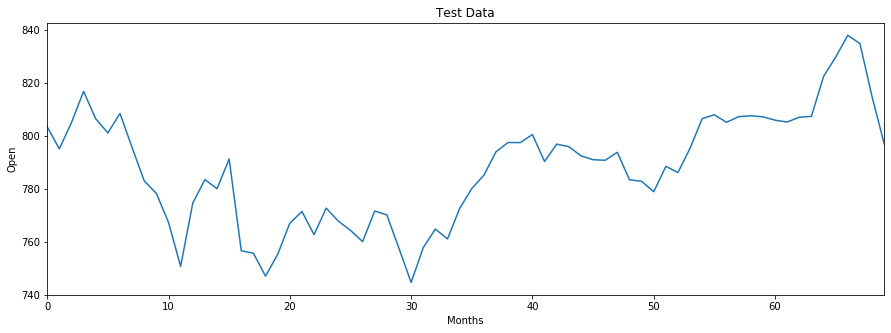

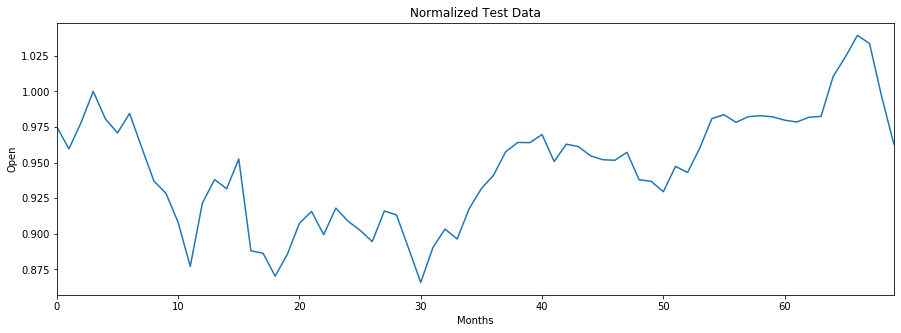

In [17]:
# Getting the real stock price of 2017
dataset_test = pd.read_csv('Stock_Price_Test.csv')
dataset_test.head()

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - timesteps:].values.reshape(-1,1)

y_test = dataset_test.loc[:, ["Open"]].values


plt.title('Test Data')
plt.ylabel('Open')
plt.xlabel('Months')
plt.grid(False)
plt.autoscale(axis='x',tight=True)
plt.plot(inputs)


#Normalizing Test Data
inputs = scaler.transform(inputs)  # min max scaler

plt.figure()
plt.title('Normalized Test Data')
plt.ylabel('Open')
plt.xlabel('Months')
plt.grid(False)
plt.autoscale(axis='x',tight=True)
plt.plot(inputs)

x_test = []

for i in range(timesteps, 70):
    x_test.append(inputs[i-timesteps:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test.shape)
print(y_test.shape)


### PyTorch Implementation

In [5]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
import torch.nn as nn

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        
        self.batch = 1
        self.num_layers = 1
        self.hidden_layer_size = 100

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first = True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(self.num_layers,self.batch,self.hidden_layer_size),
                            torch.zeros(self.num_layers,self.batch,self.hidden_layer_size))

    def forward(self, input_seq):
        
        print("Input Shape: ", input_seq.shape)
    
        input_seq = input_seq.view(1,50,1)
        print("Expanded LSTM Input Shape: ", input_seq.shape)
        
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        print("LSTM output shape: ",lstm_out.shape)
        
        print("Linear Layer Input Shape: ",lstm_out.view(-1,self.hidden_layer_size).shape)
        predictions = self.linear(lstm_out.view(-1,self.hidden_layer_size))
        
        print("Predictions shape: ",predictions.shape)
        print("Returned values for loss", predictions[-1].shape)
        print("*************************************************")
        return predictions[-1]
    

model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
print(model)

epochs = 150

for i in range(epochs):
    k = 0
    for k in range(y_train.shape[0]):
        
        optimizer.zero_grad()
        
       
        model.hidden_cell = (torch.zeros(model.num_layers, model.batch, model.hidden_layer_size),
                        torch.zeros(model.num_layers, model.batch, model.hidden_layer_size))

        y_pred = model(x_train[k])
        
        
        single_loss = loss_function(y_pred, y_train[k])
        print(single_loss.item())
        single_loss.backward()
        optimizer.step()

    
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
    



LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.008169201202690601
epoch:   0 loss: 0.00816920
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.005724109243601561
epoch:   0 loss: 0.00572411
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([5

epoch:   0 loss: 0.00002346
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.812670027196873e-05
epoch:   0 loss: 0.00002813
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.385401057836134e-05
epoch:   0 loss: 0.00002385
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00013374
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.8424206018607947e-06
epoch:   0 loss: 0.00000184
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00019175882334820926
epoch:   0 loss: 0.00019176
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.

epoch:   0 loss: 0.00013884
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.1316136048408225e-05
epoch:   0 loss: 0.00004132
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
9.537316509522498e-05
epoch:   0 loss: 0.00009537
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00109253
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0004649983602575958
epoch:   0 loss: 0.00046500
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0006297409418039024
epoch:   0 loss: 0.00062974
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00006338
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
7.490355346817523e-05
epoch:   0 loss: 0.00007490
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.530544977867976e-05
epoch:   0 loss: 0.00001531
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.0270664461131673e-06
epoch:   0 loss: 0.00000103
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.032747033808846e-05
epoch:   0 loss: 0.00002033
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.5640938474680297e-06
epoch:   0 loss: 0.00000256
Inp

epoch:   0 loss: 0.00000037
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.38545539509505e-05
epoch:   0 loss: 0.00004385
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.9335879187565297e-05
epoch:   0 loss: 0.00001934
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
7.671993807889521e-05
epoch:   0 loss: 0.00007672
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.172041786252521e-05
epoch:   0 loss: 0.00002172
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.8358354282099754e-05
epoch:   0 loss: 0.00001836
Inpu

epoch:   0 loss: 0.00104775
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.5624636944266967e-05
epoch:   0 loss: 0.00001562
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0002074910735245794
epoch:   0 loss: 0.00020749
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00000522
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.5309207558166236e-05
epoch:   0 loss: 0.00002531
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
6.603511337743839e-07
epoch:   0 loss: 0.00000066
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00001972
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.255508987531357e-07
epoch:   0 loss: 0.00000083
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00011110308696515858
epoch:   0 loss: 0.00011110
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00004394
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00029063434340059757
epoch:   0 loss: 0.00029063
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
3.0091418011579663e-05
epoch:   0 loss: 0.00003009
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.

epoch:   0 loss: 0.00006313
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.7363046228856547e-06
epoch:   0 loss: 0.00000274
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.080006743199192e-05
epoch:   0 loss: 0.00002080
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00004175
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.666957000968978e-05
epoch:   0 loss: 0.00008667
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0003002428566105664
epoch:   0 loss: 0.00030024
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00000932
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.42922327137785e-06
epoch:   0 loss: 0.00000843
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00041495051118545234
epoch:   0 loss: 0.00041495
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00011455
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
7.902314246166497e-05
epoch:   0 loss: 0.00007902
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00016376544954255223
epoch:   0 loss: 0.00016377
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.006124152336269617
epoch:   0 loss: 0.00612415
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0008399173966608942
epoch:   0 loss: 0.00083992
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.5562168957549147e-05
epoch:   0 loss: 0.00002556
Input

epoch:   0 loss: 0.00023669
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.924596477299929e-05
epoch:   0 loss: 0.00008925
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00034929902176372707
epoch:   0 loss: 0.00034930
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00026509
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0018323560943827033
epoch:   0 loss: 0.00183236
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0013434585416689515
epoch:   0 loss: 0.00134346
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00009741
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
5.287917304030998e-08
epoch:   0 loss: 0.00000005
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.415317380335182e-05
epoch:   0 loss: 0.00004415
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00024304
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0016554775647819042
epoch:   0 loss: 0.00165548
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007590113673359156
epoch:   0 loss: 0.00075901
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0002008646697504446
epoch:   0 loss: 0.00020086
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00010192287300014868
epoch:   0 loss: 0.00010192
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.50193465439952e-06
epoch:   0 loss: 0.00000450
Input

epoch:   0 loss: 0.00117260
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0012438303092494607
epoch:   0 loss: 0.00124383
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00019601831445470452
epoch:   0 loss: 0.00019602
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00020123821741435677
epoch:   0 loss: 0.00020124
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0001265347673324868
epoch:   0 loss: 0.00012653
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00022671406622976065
epoch:   0 loss: 0.00022671
Inp

epoch:   0 loss: 0.00021380
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.685611828695983e-05
epoch:   0 loss: 0.00008686
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0008613234967924654
epoch:   0 loss: 0.00086132
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.385188958622166e-07
epoch:   0 loss: 0.00000044
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00023187484475784004
epoch:   0 loss: 0.00023187
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0006033621612004936
epoch:   0 loss: 0.00060336
Inpu

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0012988048838451505
epoch:   0 loss: 0.00129880
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0015024467138573527
epoch:   0 loss: 0.00150245
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0021292311139404774
epoch:   0 loss: 0.00212923
Input

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
6.76372874295339e-05
epoch:   0 loss: 0.00006764
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
6.825586024206132e-05
epoch:   0 loss: 0.00006826
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00017216165724676102
epoch:   0 loss: 0.00017216
Input

epoch:   0 loss: 0.00004098
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0004493680316954851
epoch:   0 loss: 0.00044937
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.002047379035502672
epoch:   0 loss: 0.00204738
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   0 loss: 0.00394691
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0015328438021242619
epoch:   0 loss: 0.00153284
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
3.1329025659943e-05
epoch:   0 loss: 0.00003133
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size

epoch:   0 loss: 0.00267115
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0018555938731878996
epoch:   0 loss: 0.00185559
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0012846062891185284
epoch:   0 loss: 0.00128461
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00077535
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00054772081784904
epoch:   0 loss: 0.00054772
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0001635001099202782
epoch:   0 loss: 0.00016350
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size

epoch:   0 loss: 0.00036104
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0005009468295611441
epoch:   0 loss: 0.00050095
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0001737906422931701
epoch:   0 loss: 0.00017379
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00024387
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.077705570030957e-05
epoch:   0 loss: 0.00008078
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
3.5646826290758327e-06
epoch:   0 loss: 0.00000356
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.03983765
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.023671938106417656
epoch:   0 loss: 0.02367194
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.014071604236960411
epoch:   0 loss: 0.01407160
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size

epoch:   0 loss: 0.00758375
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.032208025455474854
epoch:   0 loss: 0.03220803
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0020187245681881905
epoch:   0 loss: 0.00201872
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0003033149987459183
epoch:   0 loss: 0.00030331
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0020299935713410378
epoch:   0 loss: 0.00202999
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.002802095841616392
epoch:   0 loss: 0.00280210
Input 

epoch:   0 loss: 0.00000029
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.6748674170230515e-05
epoch:   0 loss: 0.00001675
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.1195490515092388e-05
epoch:   0 loss: 0.00001120
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.

epoch:   0 loss: 0.00018267
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
9.741500434756745e-06
epoch:   0 loss: 0.00000974
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.001031621010042727
epoch:   0 loss: 0.00103162
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   0 loss: 0.00323724
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0012873936211690307
epoch:   0 loss: 0.00128739
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.001864130492322147
epoch:   0 loss: 0.00186413
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   0 loss: 0.00033512
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00027382769621908665
epoch:   0 loss: 0.00027383
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.002786606317386031
epoch:   0 loss: 0.00278661
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00064490
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007045129896141589
epoch:   0 loss: 0.00070451
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0010093095479533076
epoch:   0 loss: 0.00100931
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00169234
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.004881924483925104
epoch:   0 loss: 0.00488192
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00268283998593688
epoch:   0 loss: 0.00268284
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size(

epoch:   0 loss: 0.00002546
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.0339669794775546e-05
epoch:   0 loss: 0.00004034
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.1433672852945165e-07
epoch:   0 loss: 0.00000011
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.

epoch:   0 loss: 0.00089416
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0020935009233653545
epoch:   0 loss: 0.00209350
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.001892426866106689
epoch:   0 loss: 0.00189243
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00028312543872743845
epoch:   0 loss: 0.00028313
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00013987350394017994
epoch:   0 loss: 0.00013987
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
4.061644631292438e-06
epoch:   0 loss: 0.00000406
Inp

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0005660266033373773
epoch:   0 loss: 0.00056603
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0002789467398542911
epoch:   0 loss: 0.00027895
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
1.4189941794029437e-05
epoch:   0 loss: 0.00001419
Inpu

epoch:   0 loss: 0.00000162
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00019428141240496188
epoch:   0 loss: 0.00019428
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0008813172462396324
epoch:   0 loss: 0.00088132
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   0 loss: 0.00207133
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0005502947024069726
epoch:   0 loss: 0.00055029
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0014701683539897203
epoch:   0 loss: 0.00147017
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   0 loss: 0.00075532
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.001283892896026373
epoch:   0 loss: 0.00128389
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0014668061630800366
epoch:   0 loss: 0.00146681
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   1 loss: 0.00394280
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0032424675300717354
epoch:   1 loss: 0.00324247
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.002387838903814554
epoch:   1 loss: 0.00238784
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   1 loss: 0.00010086
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.68161896505626e-06
epoch:   1 loss: 0.00000868
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00010230737098027021
epoch:   1 loss: 0.00010231
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

epoch:   1 loss: 0.00014844
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
6.553366205253042e-08
epoch:   1 loss: 0.00000007
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
5.1344082748983055e-05
epoch:   1 loss: 0.00005134
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   1 loss: 0.00064713
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00019759373390115798
epoch:   1 loss: 0.00019759
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007116798660717905
epoch:   1 loss: 0.00071168
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   1 loss: 0.00034603
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0002713603025767952
epoch:   1 loss: 0.00027136
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
3.7233410239423392e-06
epoch:   1 loss: 0.00000372
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   1 loss: 0.00142302
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00076505565084517
epoch:   1 loss: 0.00076506
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0008218568400479853
epoch:   1 loss: 0.00082186
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size

epoch:   1 loss: 0.00018649
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00039627045043744147
epoch:   1 loss: 0.00039627
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0001875298039522022
epoch:   1 loss: 0.00018753
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

Returned values for loss torch.Size([1])
*************************************************
0.0009725354029797018
epoch:   1 loss: 0.00097254
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00042412054608576
epoch:   1 loss: 0.00042412
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0006069659139029682
epoch:   1 loss: 0.00060697
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Laye

Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0003589026164263487
epoch:   1 loss: 0.00035890
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.635079780106025e-07
epoch:   1 loss: 0.00000086
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
********************

epoch:   1 loss: 0.00062433
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.000887544360011816
epoch:   1 loss: 0.00088754
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0012195161543786526
epoch:   1 loss: 0.00121952
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Siz

epoch:   1 loss: 0.00035667
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0004144789418205619
epoch:   1 loss: 0.00041448
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0003116653533652425
epoch:   1 loss: 0.00031167
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0003429135831538588
epoch:   1 loss: 0.00034291
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0011014611227437854
epoch:   1 loss: 0.00110146
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0011976708192378283
epoch:   1 loss: 0.00119767
Input

Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0015761232934892178
epoch:   1 loss: 0.00157612
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0017397082410752773
epoch:   1 loss: 0.00173971
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
********************

epoch:   1 loss: 0.00021702
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00041983849951066077
epoch:   1 loss: 0.00041984
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007886714302003384
epoch:   1 loss: 0.00078867
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.S

epoch:   1 loss: 0.00000458
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
2.1063218810013495e-05
epoch:   1 loss: 0.00002106
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
3.05542052956298e-05
epoch:   1 loss: 0.00003055
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Si

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0010987082496285439
epoch:   1 loss: 0.00109871
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007773117395117879
epoch:   1 loss: 0.00077731
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.0007685060263611376
epoch:   1 loss: 0.00076851
Input

epoch:   1 loss: 0.00001233
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
5.007814252167009e-05
epoch:   1 loss: 0.00005008
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00020326413505245
epoch:   1 loss: 0.00020326
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size

Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
8.462257392238826e-05
epoch:   1 loss: 0.00008462
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00021461426513269544
epoch:   1 loss: 0.00021461
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*******************

LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00010468836990185082
epoch:   1 loss: 0.00010469
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00023687713837716728
epoch:   1 loss: 0.00023688
Input Shape:  torch.Size([50, 1])
Expanded LSTM Input Shape:  torch.Size([1, 50, 1])
LSTM output shape:  torch.Size([1, 50, 100])
Linear Layer Input Shape:  torch.Size([50, 100])
Predictions shape:  torch.Size([50, 1])
Returned values for loss torch.Size([1])
*************************************************
0.00018182792700827122
epoch:   1 loss: 0.00018183
In

KeyboardInterrupt: 

### Keras Implementation

In [19]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

x_train = np.array(x_train)
y_train = np.array(y_train)
# Fitting the RNN to the Training set
deneme = regressor.fit(x_train, y_train, epochs = 20, batch_size = 32)
  

Epoch 1/20
1208/1208 [==============================] - 3s 3ms/step - loss: 0.3893
Epoch 2/20
1208/1208 [==============================] - 1s 973us/step - loss: 0.2407 0s - loss: 0.2
Epoch 3/20
1208/1208 [==============================] - 1s 978us/step - loss: 0.1606
Epoch 4/20
1208/1208 [==============================] - 1s 997us/step - loss: 0.1196
Epoch 5/20
1208/1208 [==============================] - 1s 1ms/step - loss: 0.1054
Epoch 6/20
1208/1208 [==============================] - 1s 996us/step - loss: 0.0773
Epoch 7/20
1208/1208 [==============================] - 1s 988us/step - loss: 0.0666
Epoch 8/20
1208/1208 [==============================] - 1s 987us/step - loss: 0.0627
Epoch 9/20
1208/1208 [==============================] - 1s 982us/step - loss: 0.0540
Epoch 10/20
1208/1208 [==============================] - 1s 984us/step - loss: 0.0421
Epoch 11/20
1208/1208 [==============================] - 1s 978us/step - loss: 0.0395
Epoch 12/20
1208/1208 [=============================

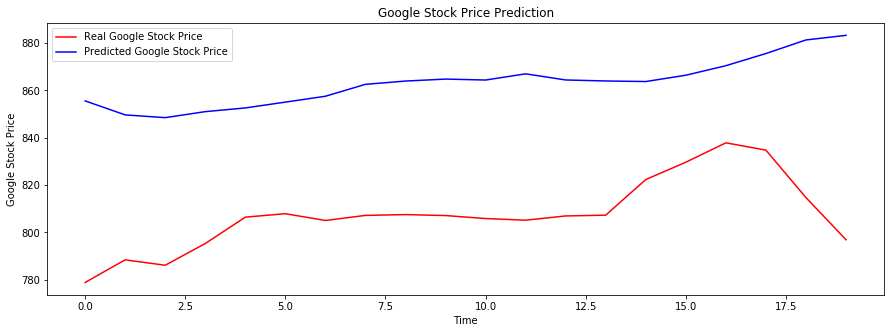

In [20]:
predictions = regressor.predict(x_test)
predictions = scaler.inverse_transform(predictions)


plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()